<a href="https://colab.research.google.com/github/patrick-nanys/text-summarization/blob/main/simple_text_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep learning homework - Milestone 2
#####Topic: NLP - text summarization
#####Authors: Patrick Nanys, Mate Jakab (Goal Diggers)

###1. Data load from xlsx 

> Source: https://www.kaggle.com/shashichander009/inshorts-news-data
> Source2.0: https://www.kaggle.com/snap/amazon-fine-food-reviews



In [51]:
import pandas as pd

#xls = pd.read_excel("Inshorts Cleaned Data.xlsx")
xls = pd.read_excel("reviews.xlsx")
# Load articles, stories
input_raw = xls['Short']
# Load headlines for articles and stories
output_raw = xls['Headline']

# Show example
print(input_raw.head(), output_raw.head())

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Short, dtype: object 0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Headline, dtype: object


###2. Taking out stopwords and shorten words (optional)
> Shortening options: lemmatizing/stemmimg



In [52]:
# nltk library and used modules
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from nltk.corpus import wordnet
from tqdm.notebook import tqdm

# Lemmatize with POS Tag (a given word gets the right POS tag)
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
print('Lemmatizing example')

words = ["dogs", "are", "better", "than", "cats"] 
for w in words:
    print(w, "\t->", WordNetLemmatizer().lemmatize(w, get_wordnet_pos(w)))

print('\nStemming example')

words = ["run", "ran", "runner", "running"] 
for w in words: 
    print(w, "->", PorterStemmer().stem(w)) 

Lemmatizing example
dogs 	-> dog
are 	-> be
better 	-> well
than 	-> than
cats 	-> cat

Stemming example
run -> run
ran -> ran
runner -> runner
running -> run


In [54]:
def takeoutstopwords_and_shorten(data, mode='none'):
    data_nltk = []

    # nltk's built in lemmatizer, stemmer and detokenizer
    lemmatizer = WordNetLemmatizer()  
    ps = PorterStemmer()
    detok = TreebankWordDetokenizer()

    # Cycle through data (range set to 10 instead of data.size until we use this)
    for i in tqdm(range(data.size)):  #range(data.size)
        # Tokenize
        tokenized = word_tokenize(data[i])
        # Take out stopwords
        without_stopword = [word for word in tokenized if not word in stopwords.words('english')]
        # Shorten if parameter 'mode' is 'lemmatize' or 'stem'
        shorter = []
        for word in without_stopword: 
            if mode == 'lemmatize':
                shorter.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
            elif mode == 'stem':
                shorter.append(ps.stem(word))
            else:
                shorter.append(word)
        # Detokenize
        back_to_string = detok.detokenize(shorter)

        data_nltk.append(back_to_string)

    return data_nltk

In [ ]:
# Take out stopwords and shorten input_raw data with lemmatize and stem
input_nltk_lemma = takeoutstopwords_and_shorten(input_raw, mode='lemmatize')
input_nltk_stem = takeoutstopwords_and_shorten(input_raw, mode='stem')

#Maybe it is useless to take out stopwords from output value (it is already short)
#output_nltk = takeoutstopwords_and_shorten(output_raw)

i = 2
print('Example\n', input_raw[i], '\n', input_nltk_lemma[i], '\n', input_nltk_stem[i])

#Not connected to tokenization yet

###3. Tokenization and padding

##### Obtaining length data

In [55]:
input_lengths = pd.Series([len(x) for x in input_raw])
output_lengths = pd.Series([len(str(x)) for x in output_raw])
print('Inputs:\n', input_lengths.describe())
print('Outputs:\n', output_lengths.describe())

Inputs:
 count    568454.000000
mean        436.225255
std         445.349016
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
dtype: float64
Outputs:
 count    568454.000000
mean         23.446018
std          14.028805
min           1.000000
25%          13.000000
50%          20.000000
75%          30.000000
max         128.000000
dtype: float64


In [56]:
# maxlen
# taking values > and round figured to 75th percentile
# at the same time not leaving high variance
encoder_maxlen = 525
decoder_maxlen = 30

Adding start and stop signs

In [57]:
# should be applied to output
def apply_start_end(data):
  return data.apply(lambda x: '<start> ' + str(x) + ' <end>')

#### Tokenization

In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(inputs, outputs):
  # since < and > from default tokens cannot be removed
  filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
  oov_token = '<unk>'

  input_tokenizer = Tokenizer(oov_token=oov_token)
  output_tokenizer = Tokenizer(filters=filters, oov_token=oov_token)

  input_tokenizer.fit_on_texts(inputs)
  output_tokenizer.fit_on_texts(outputs)

  tokenized_inputs = input_tokenizer.texts_to_sequences(inputs)
  tokenized_outputs = output_tokenizer.texts_to_sequences(outputs)

  return tokenized_inputs, tokenized_outputs, (input_tokenizer, output_tokenizer)

#### Padding

In [59]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def add_padding(inputs, outputs, encoder_maxlen, decoder_maxlen):
  padded_inputs = pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
  padded_outputs = pad_sequences(outputs, maxlen=decoder_maxlen, padding='post', truncating='post')
  return padded_inputs, padded_outputs

###4. Split dataset into train, validation and test datas

In [60]:
def dataset_split(X, Y, valid_split, test_split):
  v_start = int(len(X)*(1-valid_split-test_split))
  t_start = int(len(X)*(1-test_split))
  X_train, Y_train = X[:v_start], Y[:v_start]
  X_valid, Y_valid = X[v_start:t_start], Y[v_start:t_start]
  X_test , Y_test  = X[t_start:], Y[t_start:]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

###5. Testing

In [61]:
# Example data preprocessing

# replace unreadable part
input_raw = input_raw.replace(["&#39;"], ["'"], regex=True)
output_raw = output_raw.replace(["&#39;"], ["'"], regex=True)

start_end_output = apply_start_end(output_raw[:50000])
#lemmatized_inputs = takeoutstopwords_and_shorten(input_raw[:50000], mode='lemmatize')
tokenized_inputs, tokenized_outputs, tokenizers = tokenize(input_raw[:50000], start_end_output)
X, Y = add_padding(tokenized_inputs, tokenized_outputs, encoder_maxlen, decoder_maxlen)
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = dataset_split(X, Y, valid_split=0.2, test_split=0.1)

In [ ]:
# Run this cell to skip the above 10 minute preprocessing if you have the file below
import pickle

PICKLE_FILE = 'preprocess_save.pkl'

with open(PICKLE_FILE, 'rb') as file:
  loaded_obj = pickle.load(file)

(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, tokenizers) = loaded_obj

In [63]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((35000, 525), (35000, 30), (10000, 525), (10000, 30), (5000, 525), (5000, 30))

In [64]:
X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]

50000

In [65]:
x_vocab = len(tokenizers[0].word_index)
y_vocab = len(tokenizers[1].word_index)
x_vocab, y_vocab

(43036, 11214)

# Training

In [66]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention, Dropout

### Architecture

In [80]:
embedding_dim = 250 #50
hidden_dim = 250 #60

ENC_LSTM_NUM = 3 #3
ENC_LSTM_DROPOUT = 0.4 #0.4
ENC_LSTM_RECURRENT_DROPOUT = 0.4 #0.4

# Architecture

# Encoder
enc_emb = Embedding(x_vocab, embedding_dim)
enc_lstms = []
for i in range(ENC_LSTM_NUM):
  enc_lstms.append(LSTM(hidden_dim, return_sequences=True, return_state=True))
dropout = Dropout(ENC_LSTM_DROPOUT)

# Decoder
dec_emb = Embedding(y_vocab, embedding_dim)
dec_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
attn = Attention()
concat = Concatenate()
dec_fc = Dense(y_vocab, activation='softmax')

### Building the model

In [81]:
# Building the model

# Encoder
encoder_input = Input(shape=(encoder_maxlen,))
enc_emb_out = enc_emb(encoder_input)
lstm_in = enc_emb_out
for i in range(ENC_LSTM_NUM - 1):
  lstm_out, h, c = enc_lstms[i](lstm_in)
  lstm_out = dropout(lstm_out)
  lstm_in = lstm_out
enc_output, enc_state_h, enc_state_c = enc_lstms[-1](lstm_in)
 
# Decoder
decoder_input = Input(shape=(None,))
dec_emb_out = dec_emb(decoder_input)
dec_output, dec_state_h, dec_state_c = dec_lstm(dec_emb_out, initial_state=[enc_state_h, enc_state_c])

attn_out = attn([dec_output, enc_output])
concat_out = concat([dec_output, attn_out])
output = dec_fc(concat_out)

model = Model([encoder_input, decoder_input], output)
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 525)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 525, 250)     10759000    input_16[0][0]                   
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, 525, 250), ( 501000      embedding_6[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 525, 250)     0           lstm_13[0][0]                    
                                                                 lstm_14[0][0]        

In [82]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

### Training

In [83]:
def get_model_input(X, Y):
  """
    List of X and Y where Ys last word is excluded
  """
  return [X, Y[:,:-1]]

def get_model_output(Y):
  """
    Y input shifted right (first word excluded) and made it third dimensional
  """
  return Y.reshape(Y.shape[0],Y.shape[1], 1)[:,1:]

In [84]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint

SAVED_MODEL_PATH = 'model.hdf5'

checkpointer = ModelCheckpoint(filepath=SAVED_MODEL_PATH, save_best_only=True, verbose=0)

history = model.fit(
    get_model_input(X_train, Y_train),
    get_model_output(Y_train),
    epochs=20,
    batch_size=32, #32,
    validation_data=(
        get_model_input(X_valid, Y_valid),
        get_model_output(Y_valid)
        ),
    callbacks=[checkpointer, earlystopping]
    )

Epoch 1/20
1094/1094 [==============================] - 226s 207ms/step - loss: 1.0032 - val_loss: 0.9543
Epoch 2/20
1094/1094 [==============================] - 220s 201ms/step - loss: 0.8869 - val_loss: 0.9131
Epoch 3/20
1094/1094 [==============================] - 219s 200ms/step - loss: 0.8449 - val_loss: 0.8900
Epoch 4/20
1094/1094 [==============================] - 220s 201ms/step - loss: 0.8166 - val_loss: 0.8822
Epoch 5/20
1094/1094 [==============================] - 221s 202ms/step - loss: 0.7957 - val_loss: 0.8740
Epoch 6/20
1094/1094 [==============================] - 220s 201ms/step - loss: 0.7792 - val_loss: 0.8725
Epoch 7/20
1094/1094 [==============================] - 219s 201ms/step - loss: 0.7646 - val_loss: 0.8699
Epoch 8/20
1094/1094 [==============================] - 219s 200ms/step - loss: 0.7520 - val_loss: 0.8686
Epoch 9/20
1094/1094 [==============================] - 218s 199ms/step - loss: 0.7422 - val_loss: 0.8755
Epoch 00009: early stopping


In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics(histories):
  """
  Function for plotting the loss of models that we run.
  So its not only visible from tensorboard.
  """
  
  loss, val_loss = [], []
  for history in histories:
    loss += history.history['loss']
    val_loss += history.history['val_loss']

  epochs = [x+1 for x in range(len(loss))]

  loss_data = pd.DataFrame({'epoch':epochs, 'train_loss':loss, 'valid_loss':val_loss})
  sns.lineplot(x='epoch', y='value', hue='variable', data=pd.melt(loss_data, ['epoch']))

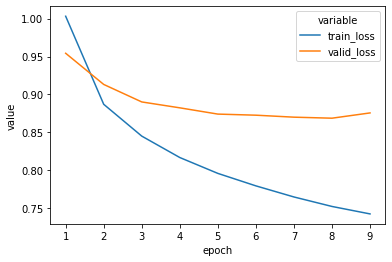

In [87]:
plot_metrics([history])

# Inference

In [88]:
# Encode
encoder_model = Model(encoder_input, [enc_output, enc_state_h, enc_state_c])

# Inputs for decode
dec_state_input_h = Input(shape=(hidden_dim,))
dec_state_input_c = Input(shape=(hidden_dim,))
dec_hidden_state_input = Input(shape=(encoder_maxlen, hidden_dim))

# Decode
dec_emb_out2 = dec_emb(decoder_input)
dec_output2, dec_state_h2, dec_state_c2 = dec_lstm(dec_emb_out2, initial_state=[dec_state_input_h, dec_state_input_c])
attn_out2 = attn([dec_output2, dec_hidden_state_input])
concat_out2 = concat([dec_output2, attn_out2])
output = dec_fc(concat_out2)

decoder_model = Model([decoder_input] + [dec_hidden_state_input, dec_state_input_h, dec_state_input_c], [output] + [dec_state_h2, dec_state_c2])

In [89]:
reverse_target_word_index=tokenizers[1].index_word
reverse_source_word_index=tokenizers[0].index_word
target_word_index=tokenizers[1].word_index

In [90]:
import numpy as np

def decode_sequence(input_seq):
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = target_word_index['<start>']

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:

    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    try:
      sampled_token = reverse_target_word_index[sampled_token_index]
    except:
      sampled_token = '<unk>'

    if(sampled_token!='<end>'):
      decoded_sentence += ' '+sampled_token

    # Exit condition: either hit max length or find stop word.
    if (sampled_token == '<end>'  or len(decoded_sentence.split()) >= (decoder_maxlen - 1)):
      stop_condition = True

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # Update internal states
    e_h, e_c = h, c

  return decoded_sentence

In [91]:
def seq2summary(input_seq):
    newString=''
    for item in input_seq:
        if(item != 0 and item != target_word_index['<start>'] and item != target_word_index['<end>']):
          try:
            new_str = reverse_target_word_index[item]
          except:
            new_str = '<unk>'
          newString = newString + new_str + ' '
    return newString

def seq2text(input_seq):
    newString=''
    for item in input_seq:
      if(item != 0):
        try:
          new_str = reverse_source_word_index[item]
        except:
          new_str = '<unk>'
        newString = newString + new_str + ' '
    return newString

In [92]:
for i in range(20):
    print("Text:",seq2text(X_train[i]))
    print("Original title:",seq2summary(Y_train[i]))
    print("Predicted title:",decode_sequence(X_train[i].reshape(1, -1)))
    print("\n")

Text: i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most 
Original title: good quality dog food 
Predicted title:  great product


Text: product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo 
Original title: not as advertised 
Predicted title:  not as good as the product


Text: this is a confection that has been around a few centuries it is a light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of c s lewis' the lion the witch an